In [29]:
import os
import sys
import random
import argparse
import json
import numpy as np
from glob import glob
from collections import namedtuple

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from reportlab.lib.pagesizes import landscape, letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib import colors

import src.network as network
import src.utils
from src.utils import ext_transforms as et
from src.metrics import StreamSegMetrics
from datasets.dataloaders import DataProcessor, KITTI360Dataset, DatasetLoader
from src.weaklabelgenerator import labelgenerator
from src.finetune_bucket import finetuner
import wandb

import sys
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import src.network as network
from datasets.kitti_360 import KittiDatasetLoader
from datasets.cityscapes_v1 import CityscapesDatasetLoader
from src.metrics import StreamSegMetrics


In [30]:
# Defining the model paths
model_name = "deeplabv3plus_resnet101"
old_model_path = 'checkpoints/best_deeplabv3plus_resnet101_cityscapes_os16.pth'
new_model_path = 'checkpoints/ranked_2k_class_SL_full_KD_pixel.pth'

# model = network.modeling.__dict__[model_name](num_classes=19, output_stride=16)

In [31]:
# Load model
def load_model(checkpoint_path, model_name='deeplabv3plus_resnet101', num_classes=19, output_stride=16):
    model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    return model

In [44]:

# Load data
def load_data(json_file, dataset_name, num_test=50):
    if dataset_name == 'cityscapes':
        dataset_loader = CityscapesDatasetLoader()
    elif dataset_name == 'kitti_360':
        dataset_loader = KittiDatasetLoader()
    else:
        raise ValueError(f"Invalid dataset: {dataset_name}")

    with open(json_file, 'r') as file:
        json_data = json.load(file)

    val_image_paths = [item.get('image') for item in json_data if item.get('image_exists')]
    val_ground_truth_paths = [item.get('ground_truth') for item in json_data if item.get('ground_truth_exists')]

    if len(val_image_paths) > num_test:
        sampled_indices = np.random.choice(len(val_image_paths), num_test, replace=False)
        val_image_paths = [val_image_paths[i] for i in sampled_indices]
        val_ground_truth_paths = [val_ground_truth_paths[i] for i in sampled_indices]

    val_dst = dataset_loader.get_datasets(val_image_paths, val_ground_truth_paths)
    val_loader = data.DataLoader(val_dst, batch_size=4, shuffle=False, num_workers=2)
    return val_loader, val_image_paths, val_ground_truth_paths


In [45]:
# Validate model
def validate(model, loader, device, metrics):
    metrics.reset()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader)):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(images)
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()
            metrics.update(targets, preds)
            all_preds.extend(preds.flatten())
            all_targets.extend(targets.flatten())
    return metrics.get_results(), all_preds, all_targets


In [46]:

# Calculate additional metrics
def calculate_additional_metrics(all_preds, all_targets, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')
    cm = confusion_matrix(all_targets, all_preds, labels=range(num_classes))
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }


In [47]:

def plot_confusion_matrix(cm, class_names, title=None, normalize=True):
    plt.figure(figsize=(12, 10))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    if title:
        plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_iou_comparison(baseline_iou, finetuned_iou, class_names, dataset_name):
    plt.figure(figsize=(15, 8))
    x = np.arange(len(class_names))
    width = 0.35

    baseline_values = [baseline_iou[i] for i in range(len(class_names))]
    finetuned_values = [finetuned_iou[i] for i in range(len(class_names))]

    plt.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
    plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned', alpha=0.8)

    plt.xlabel('Classes')
    plt.ylabel('IoU')
    plt.title(f'Class-wise IoU Comparison - {dataset_name}')
    plt.xticks(x, class_names, rotation=90)
    plt.legend()

    # Add value labels on top of each bar
    for i, v in enumerate(baseline_values):
        plt.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)
    for i, v in enumerate(finetuned_values):
        plt.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

    
def save_segmentation_maps(model, image_paths, output_dir, device, num_images=5):
    os.makedirs(output_dir, exist_ok=True)
    sampled_indices = random.sample(range(len(image_paths)), num_images)
    model.eval()
    with torch.no_grad():
        for idx in sampled_indices:
            image_path = image_paths[idx]
            image = Image.open(image_path).convert('RGB')
            image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1).unsqueeze(0).to(device)
            output = model(image_tensor).max(1)[1].cpu().numpy()[0]
            segmentation_map = Image.fromarray(output.astype(np.uint8))

            base_name = os.path.basename(image_path).split('.')[0]
            image.save(os.path.join(output_dir, f'{base_name}_original.png'))
            segmentation_map.save(os.path.join(output_dir, f'{base_name}_segmentation.png'))



In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
metrics = StreamSegMetrics(19)

Using device: cuda


In [49]:
# Load models
baseline_model = load_model(old_model_path)
finetuned_model = load_model(new_model_path)

In [50]:
# Load data
datasets = [
        ('cityscapes', 'tests/cityscapes_val_set.json'),
        ('kitti_360', 'tests/kitti-360_val_set_v3.json')
    ]

In [51]:
class_names = [
        'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
        'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
        'motorcycle', 'bicycle'
    ]


Analyzing CITYSCAPES dataset:


13it [00:54,  4.19s/it]
13it [00:49,  3.84s/it]
c:\Users\kbpra\anaconda3\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kbpra\anaconda3\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline Metrics:
Overall Acc: 0.9560081333611302
Mean Acc: 0.8237732656805111
FreqW Acc: 0.9195515204609855
Mean IoU: 0.7319028233927817
Class IoU: {0: 0.9757742541913376, 1: 0.7910853033730167, 2: 0.9311828321490937, 3: 0.5377382283826821, 4: 0.5767486450525733, 5: 0.5921836070605557, 6: 0.6735070656074442, 7: 0.7547934664113816, 8: 0.9213416038063146, 9: 0.5732709623590283, 10: 0.9593643194822884, 11: 0.8177750679452149, 12: 0.604838398021358, 13: 0.9327966608884772, 14: 0.547379944840944, 15: 0.6707148276359048, 16: 0.798505589096778, 17: 0.5061872421982417, 18: 0.7409656259602153}
Precision: 0.7487573877841384
Recall: 0.8440813159942627
F1-Score: 0.7922337555970104

Fine-tuned Metrics:
Overall Acc: 0.9092636224180343
Mean Acc: 0.7546525249438648
FreqW Acc: 0.83698151822448
Mean IoU: 0.6657280440713722
Class IoU: {0: 0.8650538484176118, 1: 0.7118847426258909, 2: 0.8302532354295112, 3: 0.47762972099496853, 4: 0.5491420001966761, 5: 0.5398309293755295, 6: 0.5736946568925821, 7: 0.713

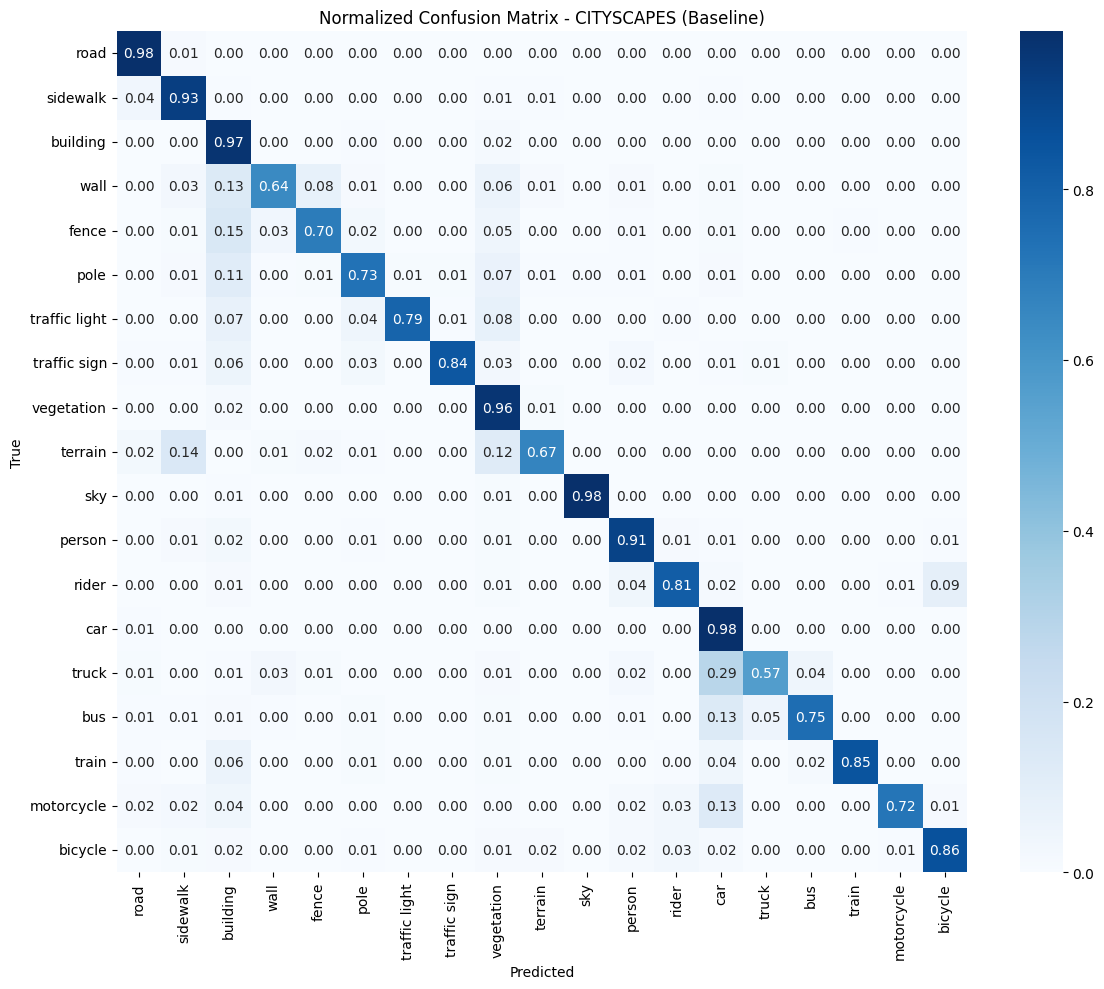

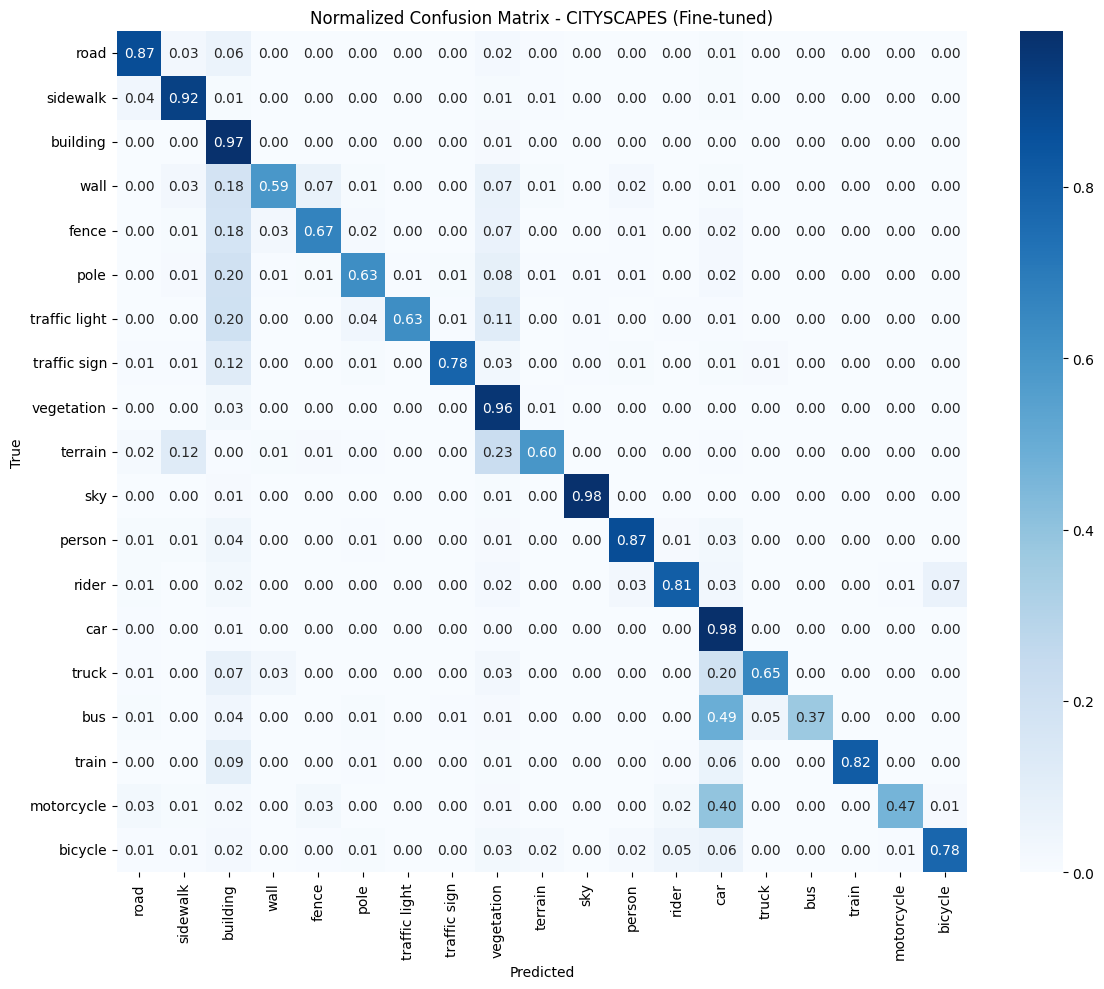

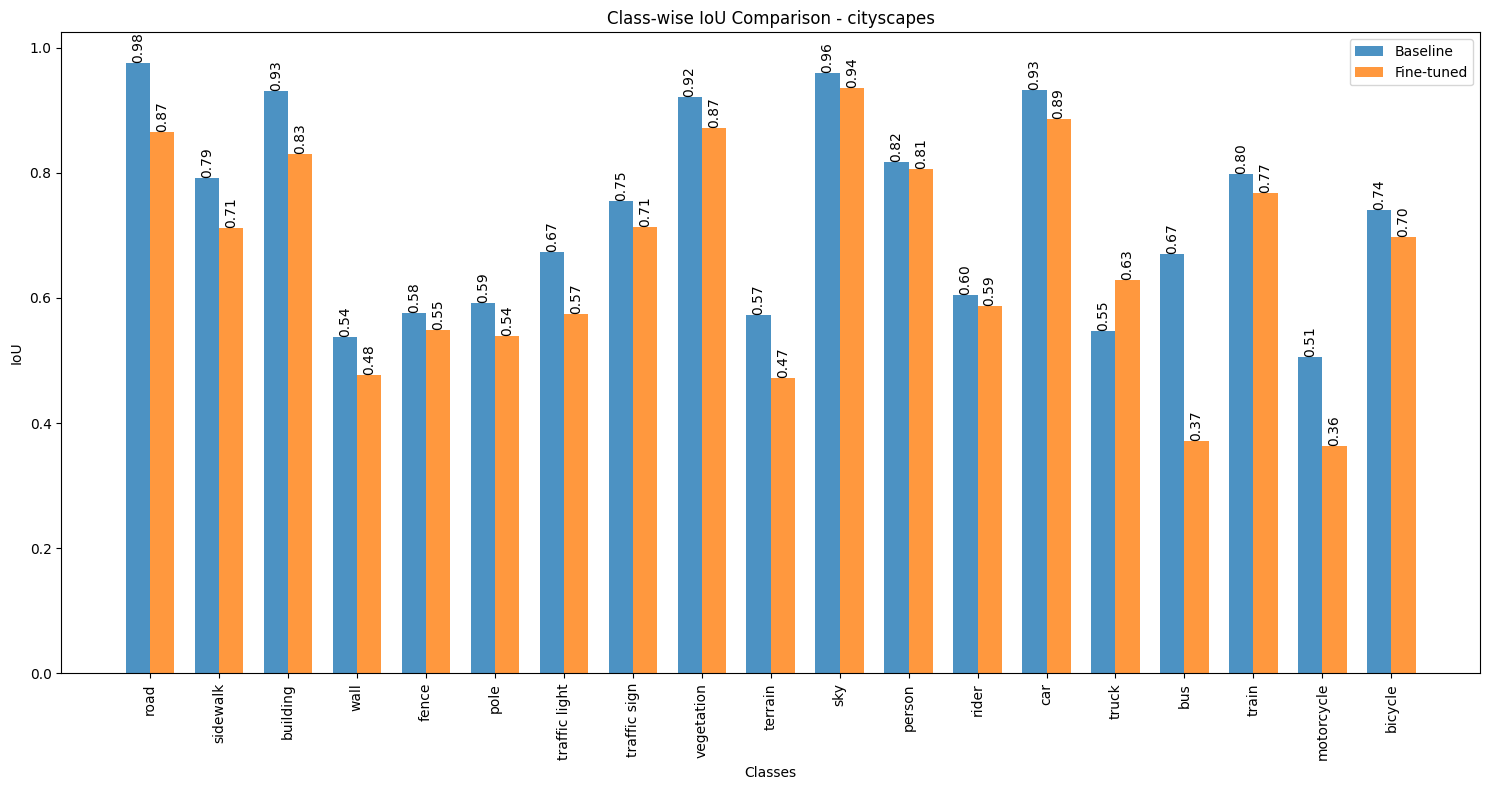


Metrics Comparison for CITYSCAPES:
        Metric  Baseline  Fine-tuned
          mIoU  0.731903    0.665728
Pixel Accuracy  0.956008    0.909264
 Mean Accuracy  0.823773    0.754653
         FWIoU  0.919552    0.836982
     Precision  0.748757    0.725354
        Recall  0.844081    0.802810
      F1-Score  0.792234    0.756222

Analyzing KITTI_360 dataset:


13it [00:15,  1.19s/it]
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:66: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
d:\DL_Lab24\Project\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:68: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
13it [00:14,  1.09s/it]
c:\Users\kbpra\anaconda3\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kbpra\anaconda3\envs\lab\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this b

Baseline Metrics:
Overall Acc: 0.7969840387532228
Mean Acc: 0.6431744308721092
FreqW Acc: 0.6773404281021155
Mean IoU: 0.3810516497704012
Class IoU: {0: 0.5887619676859185, 1: 0.41805987228152414, 2: 0.7535912107032364, 3: 0.2160840560218354, 4: 0.44632976469143726, 5: 0.32820720190830965, 6: 0.0, 7: 0.08259423503325942, 8: 0.7718080190832245, 9: 0.5006634999493577, 10: 0.8562329486475952, 11: 0.14718449887887633, 12: 0.3211179763311317, 13: 0.8213448338250335, 14: 0.4953573016982382, 15: 0.0, 16: nan, 17: 0.0, 18: 0.11159230912824342}
Precision: 0.7917138102045801
Recall: 0.7786381769825919
F1-Score: 0.7704559913538302

Fine-tuned Metrics:
Overall Acc: 0.882321403885956
Mean Acc: 0.6917006152195995
FreqW Acc: 0.7939617146543269
Mean IoU: 0.5202212488766703
Class IoU: {0: 0.8812661751359374, 1: 0.6051801364073962, 2: 0.8169427196952963, 3: 0.28307532029709054, 4: 0.5164784799051838, 5: 0.3650144902171731, 6: 0.0, 7: 0.12566263043356957, 8: 0.8318561360922182, 9: 0.7930437220292148, 10:

C:\Users\kbpra\AppData\Local\Temp\ipykernel_10604\1916915902.py:5: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


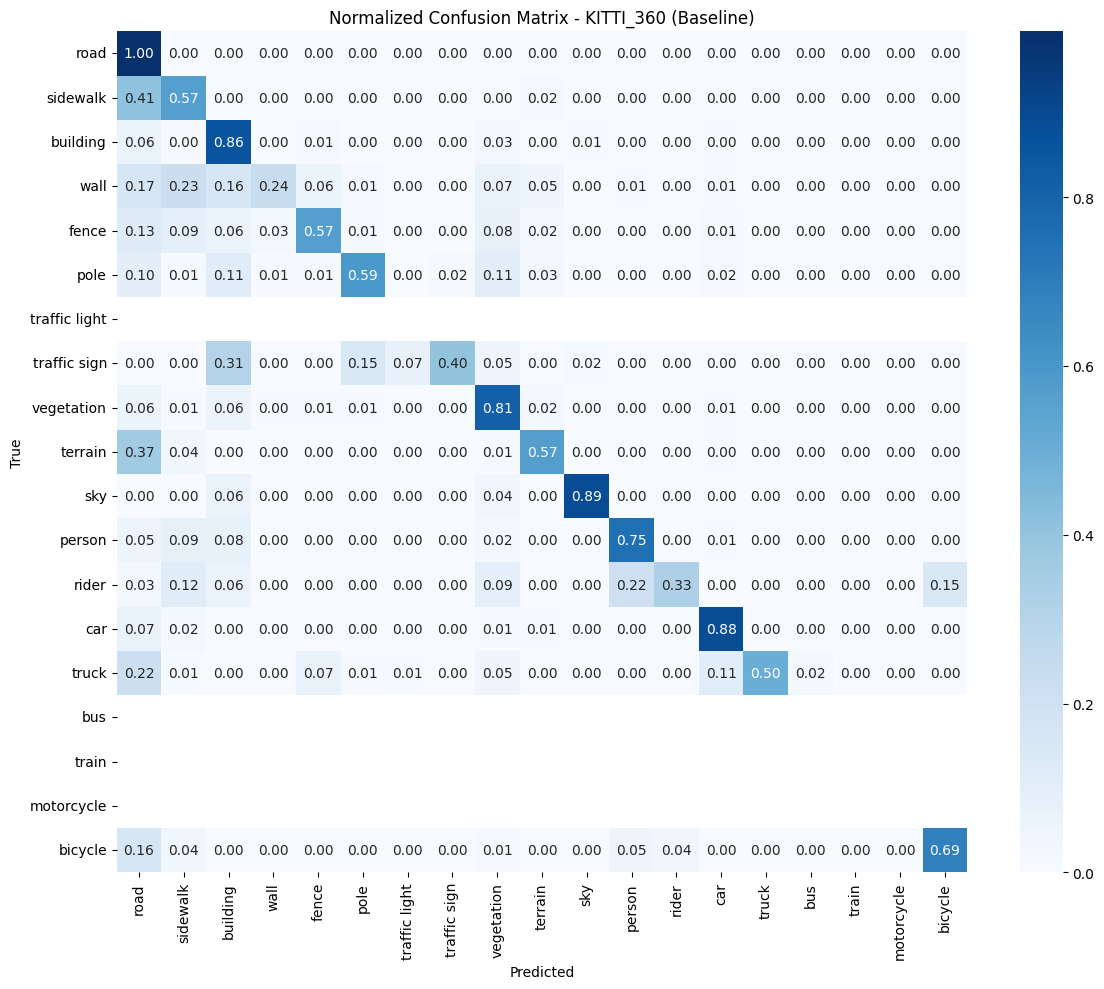

C:\Users\kbpra\AppData\Local\Temp\ipykernel_10604\1916915902.py:5: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


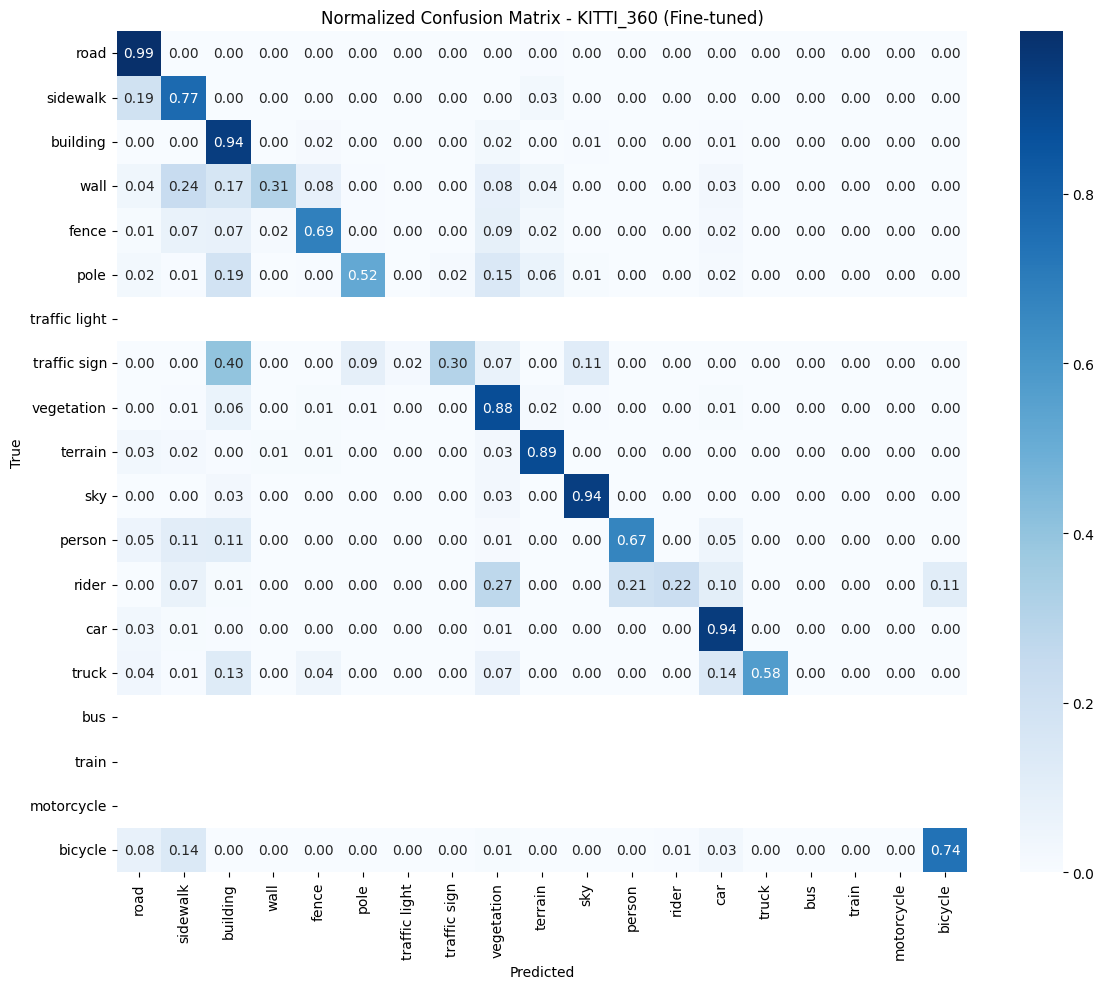

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


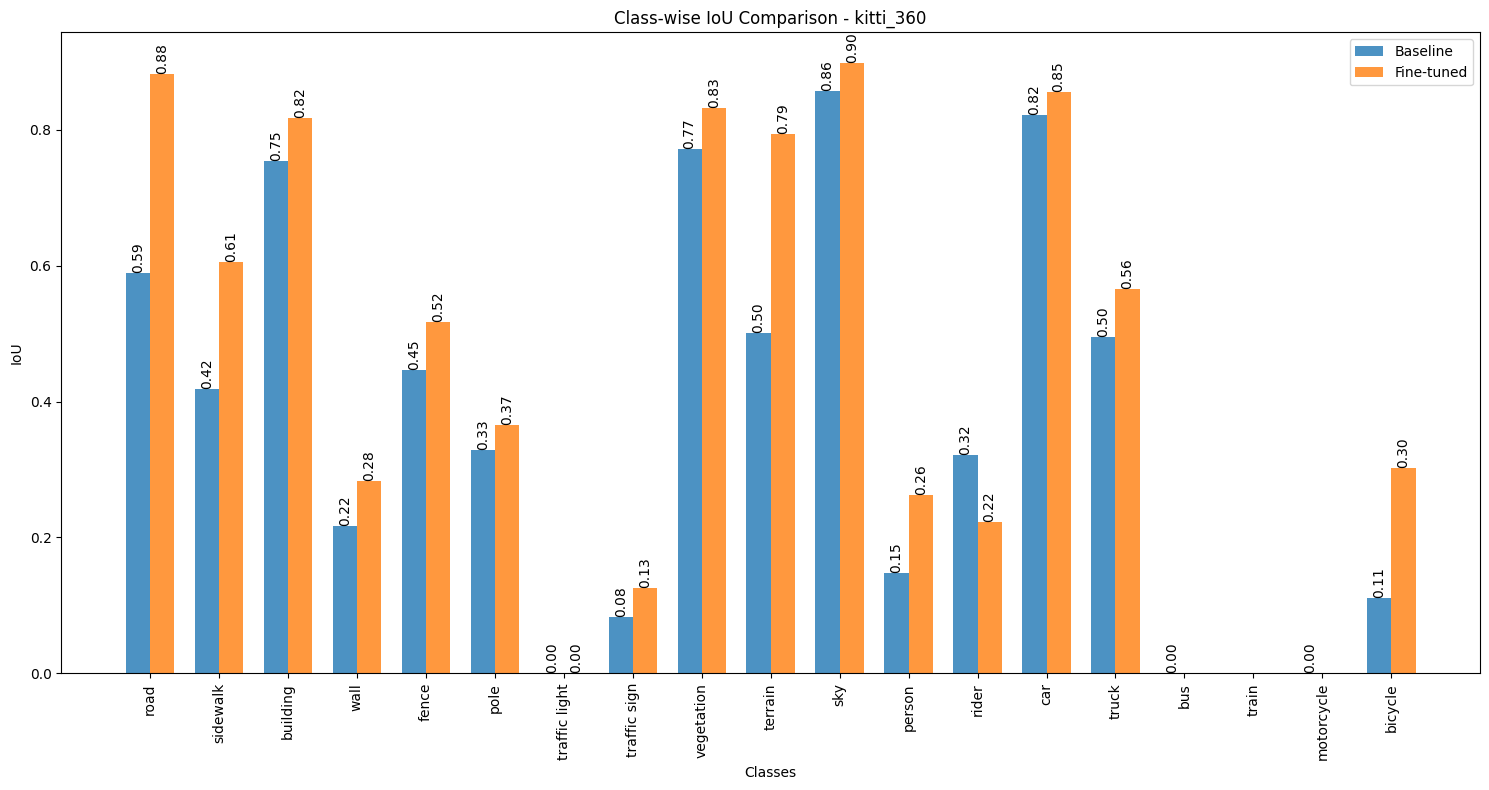


Metrics Comparison for KITTI_360:
        Metric  Baseline  Fine-tuned
          mIoU  0.381052    0.520221
Pixel Accuracy  0.796984    0.882321
 Mean Accuracy  0.643174    0.691701
         FWIoU  0.677340    0.793962
     Precision  0.791714    0.845580
        Recall  0.778638    0.862011
      F1-Score  0.770456    0.848661


In [52]:
for dataset_name, json_file in datasets:
    print(f"\nAnalyzing {dataset_name.upper()} dataset:")
    
    # Load data
    val_loader, _, _ = load_data(json_file, dataset_name)
    
    # Validate models
    baseline_results, baseline_preds, baseline_targets = validate(baseline_model, val_loader, device, metrics)
    finetuned_results, finetuned_preds, finetuned_targets = validate(finetuned_model, val_loader, device, metrics)
    
    # Calculate additional metrics
    baseline_additional = calculate_additional_metrics(baseline_preds, baseline_targets, 19)
    finetuned_additional = calculate_additional_metrics(finetuned_preds, finetuned_targets, 19)
    
    # Combine all metrics
    baseline_metrics = {**baseline_results, **baseline_additional}
    finetuned_metrics = {**finetuned_results, **finetuned_additional}
    
    # Print metrics
    print("Baseline Metrics:")
    for k, v in baseline_metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v}")
    
    print("\nFine-tuned Metrics:")
    for k, v in finetuned_metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v}")
    
    # Plot confusion matrices
    plot_confusion_matrix(baseline_metrics['Confusion Matrix'], class_names, 
                      title=f'Normalized Confusion Matrix - {dataset_name.upper()} (Baseline)', 
                      normalize=True)
    plot_confusion_matrix(finetuned_metrics['Confusion Matrix'], class_names, 
                      title=f'Normalized Confusion Matrix - {dataset_name.upper()} (Fine-tuned)', 
                      normalize=True)
    
    # Plot IoU comparison
        
    baseline_iou = [baseline_metrics['Class IoU'][i] for i in range(len(class_names))]
    finetuned_iou = [finetuned_metrics['Class IoU'][i] for i in range(len(class_names))]

    plot_iou_comparison(baseline_iou, finetuned_iou, class_names, dataset_name)
    

    # Save segmentation maps
    # save_segmentation_maps(baseline_model, val_image_paths, f'segmentation_maps/{dataset_name}/baseline', device)
    # save_segmentation_maps(finetuned_model, val_image_paths, f'segmentation_maps/{dataset_name}/finetuned', device)
    # Create a comparison table
    comparison_data = {
        'Metric': ['mIoU', 'Pixel Accuracy', 'Mean Accuracy', 'FWIoU', 'Precision', 'Recall', 'F1-Score'],
        'Baseline': [
            baseline_metrics['Mean IoU'],
            baseline_metrics['Overall Acc'],
            baseline_metrics['Mean Acc'],
            baseline_metrics['FreqW Acc'],
            baseline_metrics['Precision'],
            baseline_metrics['Recall'],
            baseline_metrics['F1-Score']
        ],
        'Fine-tuned': [
            finetuned_metrics['Mean IoU'],
            finetuned_metrics['Overall Acc'],
            finetuned_metrics['Mean Acc'],
            finetuned_metrics['FreqW Acc'],
            finetuned_metrics['Precision'],
            finetuned_metrics['Recall'],
            finetuned_metrics['F1-Score']
        ]
    }
    
    df = pd.DataFrame(comparison_data)
    print(f"\nMetrics Comparison for {dataset_name.upper()}:")
    print(df.to_string(index=False))
